In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

## Naive Gaussian-Bayesian classifier

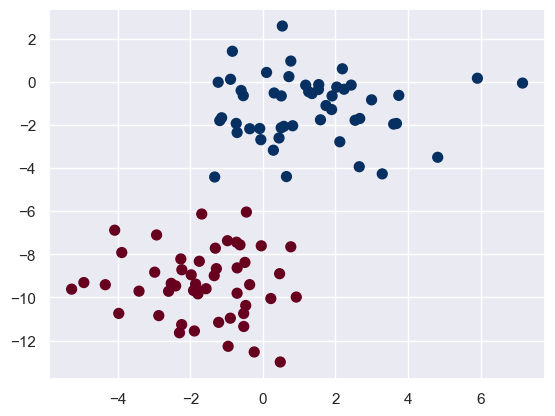

In [9]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")

In [10]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X, y)

GaussianNB()

In [7]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

(-5.890554373486014,
 7.777566725032841,
 -13.775943665162341,
 3.3634536696825847)

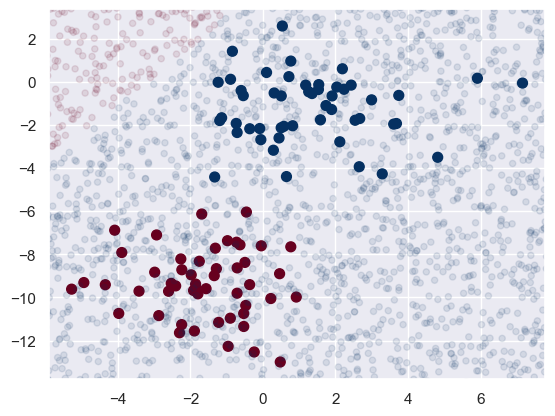

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap="RdBu", alpha=0.1)
plt.axis(lim)

In [12]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

### Polynomial naive Bayesian classifier

In [13]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [15]:
categories = ["talk.religion.misc", "soc.religion.christian", "sci.space", "comp.graphics"]
train = fetch_20newsgroups(subset="train", categories=categories)
test = fetch_20newsgroups(subset="test", categories=categories)

In [16]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())


In [18]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Text(110.44999999999996, 0.5, 'prediction label')

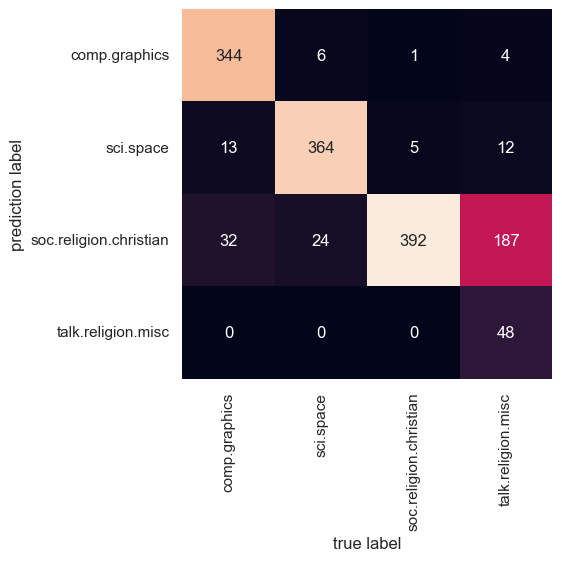

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel("true label")
plt.ylabel("prediction label")

In [20]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [21]:
predict_category("sending payload to ISS")

'sci.space'

In [22]:
predict_category("screen resolution")

'comp.graphics'

## Deeper look into linear regression

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np


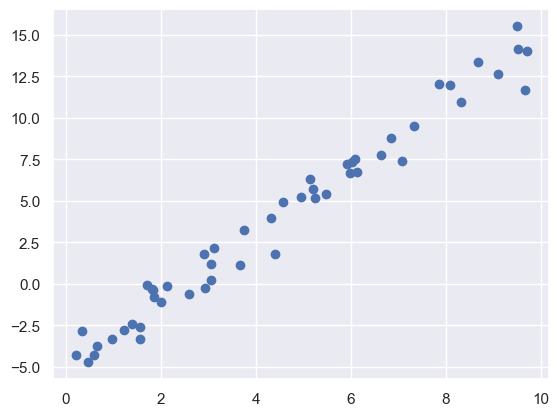

In [2]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

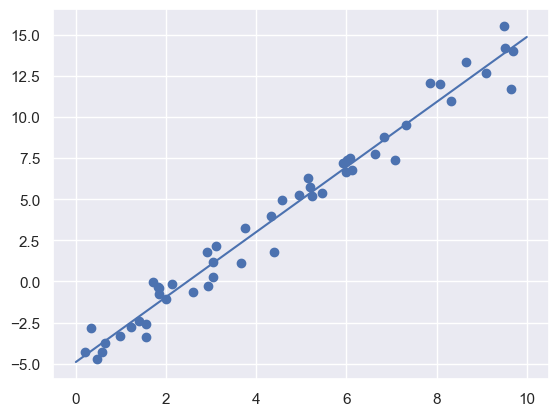

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

In [4]:
print(f"Model slope: {model.coef_[0]}")
print(f"Model intercept: {model.intercept_}")

Model slope: 1.9776566003853098
Model intercept: -4.903310725531111


In [5]:
# Polynomial features

from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [6]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

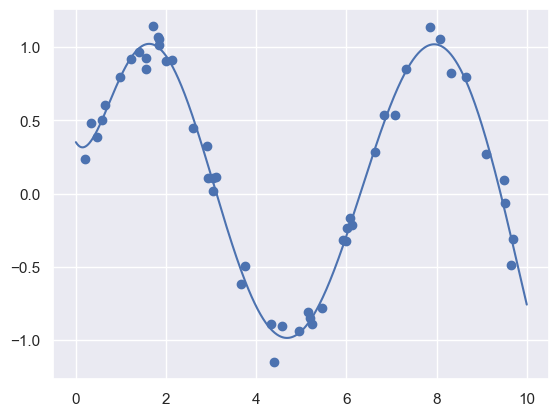

In [7]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

In [8]:
# Gaussian basis functions

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Normally distributed Gaussian features for 1 dimentional input data
    """

    def __init__(self, N, width_factor=2.0):
        self._n = N
        self._width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self._n)
        self.width_ = self._width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)
    

(0.0, 10.0)

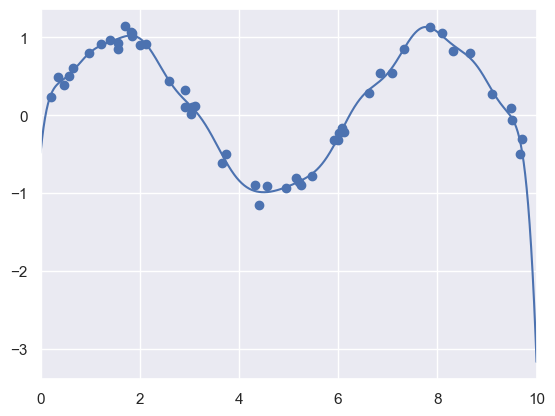

In [9]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())

gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)